# ML-Ensemble: Scikit-learn style ensemble learning
By FLNR

Source: https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning/notebook

Documentation: http://mlens.readthedocs.io/en/latest/index.html

In [8]:
import gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from mlens.preprocessing import EnsembleTransformer

# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint
import os

from matplotlib.pyplot import show
%matplotlib inline

In [9]:
SEED = 148
np.random.seed(SEED)

path = r"D:/My Computer/DATA/Zillow"

In [10]:
def build_train():
    """Read in training data and return input, output, columns tuple."""

    # This is a version of Anovas minimally prepared dataset
    # for the xgbstarter script
    # https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655

    df = pd.read_csv(open(os.path.join(path, "train_2016_v2.csv"), "r"))

    prop = pd.read_csv(open(os.path.join(path, "properties_2016.csv"), "r"))
    convert = prop.dtypes == 'float64'
    prop.loc[:, convert] = \
        prop.loc[:, convert].apply(lambda x: x.astype(np.float32))

    df = df.merge(prop, how='left', on='parcelid')

    y = df.logerror
    df = df.drop(['parcelid',
                  'logerror',
                  'transactiondate',
                  'propertyzoningdesc',
                  'taxdelinquencyflag',
                  'propertycountylandusecode'], axis=1)

    convert = df.dtypes == 'object'
    df.loc[:, convert] = \
        df.loc[:, convert].apply(lambda x: 1 * (x == True))

    df.fillna(0, inplace=True)

    return df, y, df.columns

D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
D:\WindowsApps\Anaconda\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


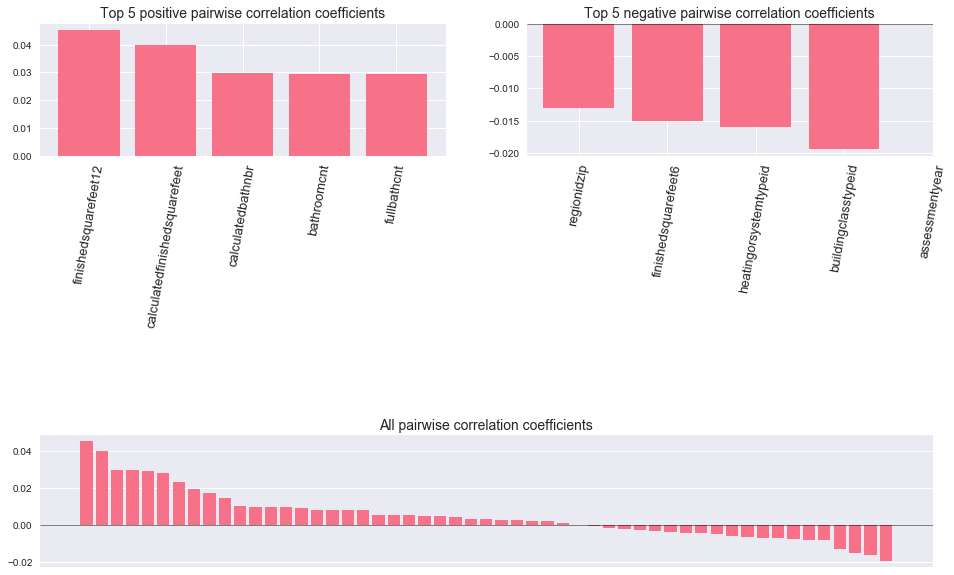

In [11]:
xtrain, ytrain, columns = build_train()
xtrain, xtest, ytrain, ytest = train_test_split(xtrain,
                                                ytrain,
                                                test_size=0.5,
                                                random_state=SEED)

# this plot requires mlens 0.1.3, Kaggle is currently on 0.1.2
corr_X_y(xtrain, ytrain, figsize=(16, 10), label_rotation=80, hspace=1, fontsize=14)

In [12]:
# We consider the following models (or base learners)
gb = XGBRegressor(n_jobs=1, random_state=SEED)
ls = Lasso(alpha=1e-6, normalize=True)
el = ElasticNet(alpha=1e-6, normalize=True)
rf = RandomForestRegressor(random_state=SEED)

base_learners = [('ls', ls),
                 ('el', el),
                 ('rf', rf),
                 ('gb', gb)
                ]

In [13]:
P = np.zeros((xtest.shape[0], len(base_learners)))
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    est.fit(xtrain, ytrain)
    p = est.predict(xtest)
    P.loc[:, est_name] = p
    print("%3s : %.4f" % (est_name, mean_absolute_error(ytest, p)))

 ls : 0.0687
 el : 0.0687
 rf : 0.0826
 gb : 0.0689


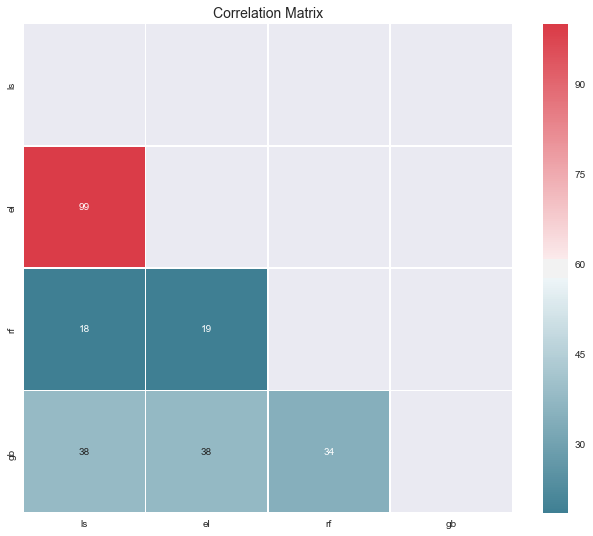

In [14]:
ax = corrmat(P.corr())
show()

In [15]:
# Put their parameter dictionaries in a dictionary with the
# estimator names as keys
param_dicts = {'ls':
                  {'alpha': uniform(1e-6, 1e-5)},
               'el':
                  {'alpha': uniform(1e-6, 1e-5),
                   'l1_ratio': uniform(0, 1)},
               'gb':
                   {'learning_rate': uniform(0.02, 0.04),
                    'colsample_bytree': uniform(0.55, 0.66),
                    'min_child_weight': randint(30, 60),
                    'max_depth': randint(3, 7),
                    'subsample': uniform(0.4, 0.2),
                    'n_estimators': randint(150, 200),
                    'colsample_bytree': uniform(0.6, 0.4),
                    'reg_lambda': uniform(1, 2),
                    'reg_alpha': uniform(1, 2),
                   },
               'rf':
                   {'max_depth': randint(2, 5),
                    'min_samples_split': randint(5, 20),
                    'min_samples_leaf': randint(10, 20),
                    'n_estimators': randint(50, 100),
                    'max_features': uniform(0.6, 0.3)}
              }

In [16]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

evl = Evaluator(scorer,
                cv=2,
                random_state=SEED,
                verbose=5,
               )

In [17]:
evl.fit(xtrain.values,  # you can pass DataFrames from mlens>=0.1.3 
        ytrain.values,
        estimators=base_learners,
        param_dicts=param_dicts,
        preprocessing={'sc': [StandardScaler()], 'none': []},
        n_iter=2)  # bump this up to do a larger grid search

Preprocessing 2 preprocessing pipelines over 2 CV folds
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
Preprocessing done | 00:00:00

Evaluating 8 models for 2 parameter draws over 2 preprocessing pipelines and 2 CV folds, totalling 32 fits
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  32 | elapsed:   12.4s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   20.3s finished
Evaluation done | 00:00:20



In [18]:
pd.DataFrame(evl.summary)

fit_time_mean  fit_time_std  test_score_mean  test_score_std  \
none el       0.352384      0.020658        -0.068177        0.000681   
     gb      11.712573      0.103099        -0.068905        0.000645   
     ls       0.325376      0.198396        -0.068181        0.000703   
     rf       5.663835      0.068047        -0.068067        0.000717   
sc   el       0.252014      0.066959        -0.068177        0.000681   
     gb       8.922029      0.953834        -0.068920        0.000643   
     ls       0.198059      0.034196        -0.068181        0.000703   
     rf       4.720216      0.311536        -0.068067        0.000717   

         train_score_mean  train_score_std  \
none el         -0.068068         0.000691   
     gb         -0.066794         0.000795   
     ls         -0.068103         0.000640   
     rf         -0.067698         0.000646   
sc   el         -0.068068         0.000691   
     gb         -0.066790         0.000783   
     ls         -0.068103         0.000640   
     rf         -0.067698         0.000646   

                                                    params  
none el  {'l1_ratio': 0.575405852231, 'alpha': 6.754058...  
     gb  {'subsample': 0.515081170446, 'reg_lambda': 2....  
     ls                       {'alpha': 6.75405852231e-06}  
     rf  {'max_features': 0.642092522176, 'max_depth': ...  
sc   el  {'l1_ratio': 0.575405852231, 'alpha': 6.754058...  
     gb  {'subsample': 0.515081170446, 'reg_lambda': 2....  
     ls                       {'alpha': 6.75405852231e-06}  
     rf  {'max_features': 0.642092522176, 'max_depth': ...

In [19]:
evl.summary["params"][('sc', 'gb')]

{'colsample_bytree': 0.83016234089249397,
 'learning_rate': 0.0430162340892494,
 'max_depth': 6,
 'min_child_weight': 49,
 'n_estimators': 169,
 'reg_alpha': 2.1508117044624697,
 'reg_lambda': 2.1508117044624697,
 'subsample': 0.51508117044624702}

In [22]:
for case_name, params in evl.summary["params"].items():
    for est_name, est in base_learners:
        if est_name == case_name[1]:
            est.set_params(**params)

# We will compare a GBM and an elastic net as the meta learner
# These are cloned internally so we can go ahead and grab the fitted ones
meta_learners = [('gb', gb),
                 ('el', el)]

# Note that when we have a preprocessing pipeline,
# keys are in the (prep_name, est_name) format
param_dicts = {'el':
                  {'alpha': uniform(1e-5, 1),
                   'l1_ratio': uniform(0, 1)},
               'gb':
                   {'learning_rate': uniform(0.01, 0.2),
                    'subsample': uniform(0.5, 0.5),
                    'reg_lambda': uniform(0.1, 1),
                    'n_estimators': randint(10, 100)},
              }

In [33]:
# Here, we but the base learners in an EnsembleTransformer class
# this class will faithfully reproduce predictions for each fold
# in a cross-validation execution as if it was the first n layers
# of an ensemble

# The API of the Ensemble transformer mirrors that of the SequentialEnsemble class,
# see documentation for further info
in_layer = EnsembleTransformer()
in_layer.add('stack', base_learners)

preprocess = [in_layer]

evl.fit(xtrain.values,
        ytrain.values,
        meta_learners,
        param_dicts,
        preprocessing={'meta': preprocess},
        n_iter=20                            # bump this up to do a larger grid search
       )

Preprocessing 1 preprocessing pipelines over 2 CV folds
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.8s finished
Preprocessing done | 00:00:20

Evaluating 2 models for 20 parameter draws over 1 preprocessing pipelines and 2 CV folds, totalling 80 fits
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.9s finished
Evaluation done | 00:00:17



In [34]:
pd.DataFrame(evl.summary)

fit_time_mean  fit_time_std  test_score_mean  test_score_std  \
meta el       0.036102      0.032550        -0.068227        0.000795   
     gb       0.674565      0.063624        -0.068956        0.000509   

         train_score_mean  train_score_std  \
meta el         -0.068217         0.000593   
     gb         -0.068197         0.000728   

                                                    params  
meta el  {'l1_ratio': 0.575405852231, 'alpha': 0.575415...  
     gb  {'subsample': 0.783685684531, 'reg_lambda': 0....

In [35]:
# Let's pick the linear meta learner with the above tuned
# hyper-parameters. Note that ideally, you'd want to tune
# the ensemble as a whole, not each estimator at a time
meta_learner = meta_learners[1][1]

meta_learner.set_params(**evl.summary["params"][("meta", "el")])

ElasticNet(alpha=0.57541585223123481, copy_X=True, fit_intercept=True,
      l1_ratio=0.57540585223123486, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
# Instantiate the ensemble by adding layers to it. Finalize with a meta layer
ens = SuperLearner(verbose=5,
                   backend="threading") # mlens can release the GIL
ens.add(base_learners)
ens.add_meta(meta_learner)

SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None, dtype=<class 'numpy.float32'>,
   estimators=[('ls', Lasso(alpha=6.7540585223123488e-06, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precomput...xception=True, scorer=None,
   verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

In [37]:
ens.fit(xtrain, ytrain)

Fitting 2 layers
Processing layer-1
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    6.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.5s finished
layer-1 Done | 00:00:15

Processing layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00

Fit complete | 00:00:15



SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None, dtype=<class 'numpy.float32'>,
   estimators=[('ls', Lasso(alpha=6.7540585223123488e-06, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precomput...xception=True, scorer=None,
   verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

In [38]:
pred = ens.predict(xtest)

Predicting with 2 layers
Processing layer-1
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
layer-1 Done | 00:00:00

Processing layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00

Prediction complete | 00:00:00



In [39]:
print("ensemble score: %.4f" % mean_absolute_error(ytest, pred))

ensemble score: 0.0688
